# Penulisan Ilmiah
## Datadiri :
>
> Nama : Muhammad Faqih Hakim
>
> NPM : 51422032

In [1]:
!pip install -q roboflow

In [2]:
!pip install -q ultralytics

In [3]:
import yaml
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import random
import itertools
from ultralytics import YOLO
from roboflow import Roboflow
import pandas as pd
from google.colab import files
from datetime import datetime

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
rf = Roboflow(api_key="jFj6dO8DDczUZ9kJ1xuo")
project = rf.workspace("kkkk-6bpnc").project("kk-8ucwu")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to kk-2 in yolov8:: 100%|██████████| 14612/14612 [00:01<00:00, 9691.61it/s] 


In [5]:
train_images_path = "/content/kk-2/train/images"
train_labels_path = "/content/kk-2/train/labels"

In [6]:
image_files = [f for f in os.listdir(train_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_files = random.sample(image_files, min(12, len(image_files)))

In [7]:
def draw_bounding_boxes(img, label_path):
    h, w = img.shape[:2]
    with open("/content/kk-2/data.yaml", 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                x_center *= w
                y_center *= h
                width *= w
                height *= h

                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)

                color = (0, 255, 0)
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
                text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                text_y = y1 - 5 if y1 - 5 > text_size[1] else y2 + text_size[1] + 5
                cv2.putText(img, class_name, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

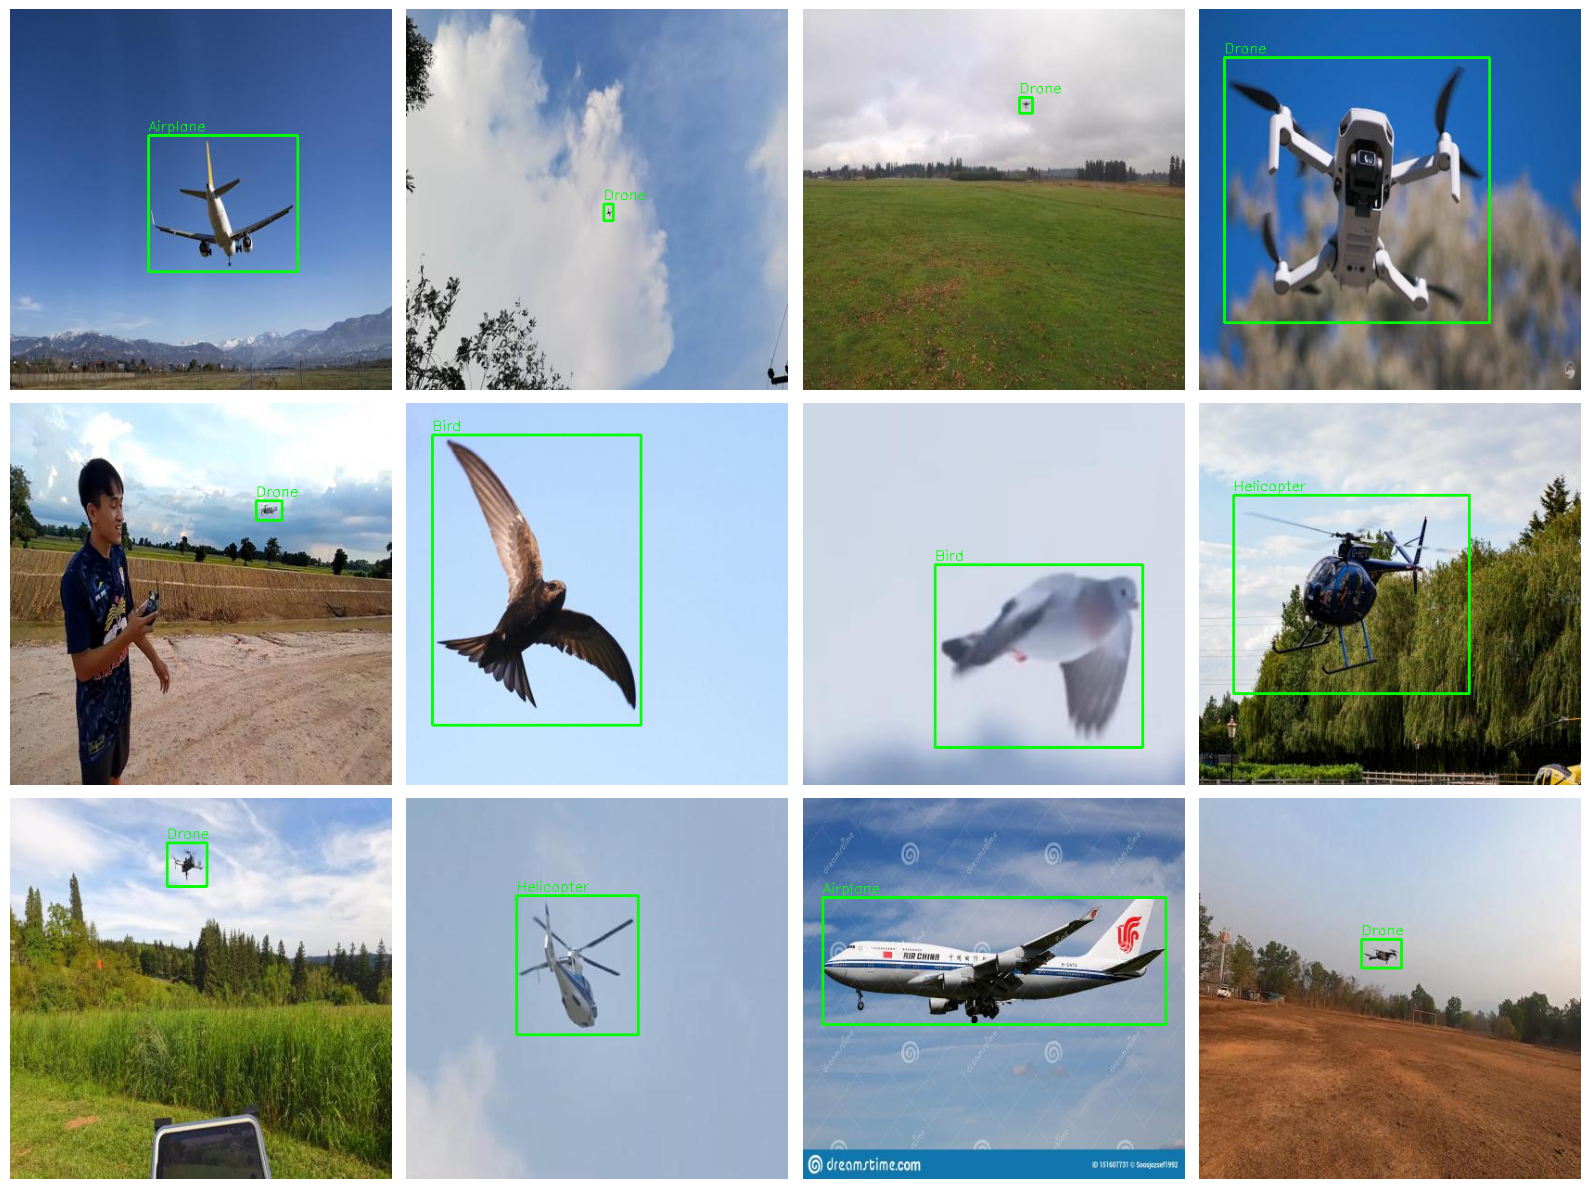

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, img_file in enumerate(sample_files):
    img_path = os.path.join(train_images_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_file = img_file.rsplit('.', 1)[0] + '.txt'
    label_path = os.path.join(train_labels_path, label_file)

    img = draw_bounding_boxes(img, label_path)

    axes[i].imshow(img)
    axes[i].axis('off')

for i in range(len(sample_files), 12):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
learning_rates = [0.0005, 0.001]
batch_sizes = [8]
weight_decays = [0.0005, 0.001]
optimizers = ['Adam']

In [10]:
combos = list(itertools.product(learning_rates, batch_sizes, weight_decays, optimizers))
print(f"Total kombinasi: {len(combos)}")
for i, (lr, batch, wd, opt) in enumerate(combos):
    print(f"Kombinasi {i+1}: LR={lr}, Batch={batch}, WD={wd}, Optimizer={opt}")

Total kombinasi: 4
Kombinasi 1: LR=0.0005, Batch=8, WD=0.0005, Optimizer=Adam
Kombinasi 2: LR=0.0005, Batch=8, WD=0.001, Optimizer=Adam
Kombinasi 3: LR=0.001, Batch=8, WD=0.0005, Optimizer=Adam
Kombinasi 4: LR=0.001, Batch=8, WD=0.001, Optimizer=Adam


In [12]:
for i, (lr, batch, weight_decay, optimizer) in enumerate(combos):
    print("=" * 60)
    print(f"Training Model {i+1}/{len(combos)}")
    print(f"Start Time   : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Parameters  : lr={lr}, batch={batch}, weight_decay={weight_decay}, optimizer={optimizer}")
    print(f"Dir Save Name   : run_{i+1}_lr{lr}_b{batch}_wd{weight_decay}_{optimizer}")
    print("=" * 60)

    model = YOLO("yolov10n.pt")

    model.train(
        data="/content/kk-2/data.yaml",
        epochs=15,
        imgsz=640,
        batch=batch,
        lr0=lr,
        optimizer=optimizer,
        weight_decay=weight_decay,

        # Regularization
        warmup_epochs=3,
        dropout=0.1,
        patience=10,

        # Augmentation
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=10.0,
        translate=0.1,
        scale=0.5,
        shear=2.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.1,
        copy_paste=0.1,

        # Output
        name=f"YOLOV10_run_{i+1}_lr{lr}_b{batch}_wd{weight_decay}_{optimizer}",
        plots=False,
        save=True,
        save_period=10,
        verbose=False,
        device=0
    )

Training Model 1/4
Start Time   : 2025-06-02 11:39:15
Parameters  : lr=0.0005, batch=8, weight_decay=0.0005, optimizer=Adam
Dir Save Name   : run_1_lr0.0005_b8_wd0.0005_Adam


100%|██████████| 5.59M/5.59M [00:00<00:00, 350MB/s]


Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/kk-2/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots

100%|██████████| 755k/755k [00:00<00:00, 97.1MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

YOLOv10n summary: 223 layers, 2,708,600 parameters, 2,708,584 gradients, 8.4 GFLOPs

Transferred 493/595 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 299MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 601.1±311.2 MB/s, size: 15.4 KB)


train: Scanning /content/kk-2/train/labels... 5767 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5767/5767 [00:02<00:00, 2056.10it/s]


train: New cache created: /content/kk-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.6 ms, read: 448.1±281.0 MB/s, size: 17.3 KB)


val: Scanning /content/kk-2/valid/labels... 778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 778/778 [00:00<00:00, 1043.69it/s]


val: New cache created: /content/kk-2/valid/labels.cache
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.49G      2.926      4.813      3.061         11        640: 100%|██████████| 721/721 [02:42<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.66it/s]


                   all        778        843      0.337      0.487      0.397      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.74G      2.789      3.684      2.965         23        640: 100%|██████████| 721/721 [02:27<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.49it/s]

                   all        778        843      0.523      0.574      0.577      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.75G      2.747      3.381      2.936         19        640: 100%|██████████| 721/721 [02:29<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.78it/s]

                   all        778        843      0.622      0.597      0.648      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.77G      2.662      3.143      2.885         11        640: 100%|██████████| 721/721 [02:27<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.74it/s]

                   all        778        843      0.741      0.706      0.782      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.79G       2.61      2.933      2.854         13        640: 100%|██████████| 721/721 [02:26<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.52it/s]

                   all        778        843      0.824      0.725      0.837       0.56


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15       1.8G      2.273      1.869      2.666          7        640: 100%|██████████| 721/721 [02:20<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.32it/s]

                   all        778        843      0.789      0.715      0.829      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.82G      2.228      1.639      2.625          7        640: 100%|██████████| 721/721 [02:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.40it/s]

                   all        778        843      0.817      0.773      0.856       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.83G      2.139      1.529      2.546          8        640: 100%|██████████| 721/721 [02:20<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.37it/s]

                   all        778        843      0.782      0.822      0.881      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.85G       2.11        1.4      2.521          8        640: 100%|██████████| 721/721 [02:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.44it/s]

                   all        778        843      0.831      0.817      0.898      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.86G      2.075      1.309      2.499          7        640: 100%|██████████| 721/721 [02:19<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.32it/s]

                   all        778        843      0.849      0.851      0.917      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.88G      2.011      1.223       2.45          7        640: 100%|██████████| 721/721 [02:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.33it/s]

                   all        778        843      0.869      0.849      0.934      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.89G      1.987      1.176      2.433          7        640: 100%|██████████| 721/721 [02:21<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.33it/s]

                   all        778        843      0.865      0.858      0.938      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.91G      1.923      1.121      2.381          8        640: 100%|██████████| 721/721 [02:20<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.36it/s]

                   all        778        843       0.92       0.87       0.95      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.93G      1.884      1.047       2.36          8        640: 100%|██████████| 721/721 [02:22<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.98it/s]


                   all        778        843      0.869      0.883      0.947      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.94G      1.854      1.013      2.341          7        640: 100%|██████████| 721/721 [02:20<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]

                   all        778        843      0.928      0.842      0.953      0.734



15 epochs completed in 0.634 hours.
Optimizer stripped from runs/detect/YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam/weights/best.pt, 5.7MB

Validating runs/detect/YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:05<00:00,  8.68it/s]

                   all        778        843       0.93      0.842      0.953      0.734
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 0.2ms postprocess per image


Training Model 2/4
Start Time   : 2025-06-02 12:17:46
Parameters  : lr=0.0005, batch=8, weight_decay=0.001, optimizer=Adam
Dir Save Name   : run_2_lr0.0005_b8_wd0.001_Adam
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/kk-2/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scal

train: Scanning /content/kk-2/train/labels.cache... 5767 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5767/5767 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 281.1±199.0 MB/s, size: 17.3 KB)


val: Scanning /content/kk-2/valid/labels.cache... 778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 778/778 [00:00<?, ?it/s]


optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.001), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOV10_run_2_lr0.0005_b8_wd0.001_Adam
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.64G       2.93      4.738      3.061         11        640: 100%|██████████| 721/721 [02:44<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.56it/s]

                   all        778        843      0.404      0.539      0.436      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.87G      2.773      3.634      2.955         23        640: 100%|██████████| 721/721 [02:34<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.66it/s]


                   all        778        843      0.678      0.572      0.667      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.87G      2.741      3.354       2.93         19        640: 100%|██████████| 721/721 [02:31<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.51it/s]

                   all        778        843      0.689       0.64      0.712      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.87G      2.652      3.125      2.888         11        640: 100%|██████████| 721/721 [02:32<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.42it/s]

                   all        778        843      0.764      0.703      0.795      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.87G      2.619        2.9      2.856         13        640: 100%|██████████| 721/721 [02:32<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.18it/s]

                   all        778        843      0.786      0.728      0.823      0.533


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.87G      2.269       1.84      2.661          7        640: 100%|██████████| 721/721 [02:23<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.39it/s]

                   all        778        843      0.812      0.742      0.847      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.87G        2.2      1.635      2.592          7        640: 100%|██████████| 721/721 [02:22<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]

                   all        778        843      0.777      0.783      0.858      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.87G       2.13      1.488      2.531          8        640: 100%|██████████| 721/721 [02:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.25it/s]

                   all        778        843      0.819      0.771      0.874      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.87G      2.108      1.398      2.513          8        640: 100%|██████████| 721/721 [02:19<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.50it/s]

                   all        778        843      0.824      0.804      0.894      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.87G      2.058      1.323      2.484          7        640: 100%|██████████| 721/721 [02:19<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.64it/s]

                   all        778        843      0.829      0.869      0.922      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.87G       2.01       1.25      2.445          7        640: 100%|██████████| 721/721 [02:19<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.46it/s]

                   all        778        843       0.88      0.819       0.92      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.87G      1.977      1.167      2.431          7        640: 100%|██████████| 721/721 [02:20<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.51it/s]

                   all        778        843      0.879      0.882      0.935      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.87G       1.92      1.119      2.373          8        640: 100%|██████████| 721/721 [02:19<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.53it/s]

                   all        778        843      0.872      0.873      0.942      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.87G      1.868      1.043      2.351          8        640: 100%|██████████| 721/721 [02:19<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.94it/s]

                   all        778        843      0.913      0.835      0.945      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.87G      1.835      1.008       2.32          7        640: 100%|██████████| 721/721 [02:18<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.55it/s]

                   all        778        843      0.914      0.857      0.955      0.731



15 epochs completed in 0.637 hours.
Optimizer stripped from runs/detect/YOLOV10_run_2_lr0.0005_b8_wd0.001_Adam/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/YOLOV10_run_2_lr0.0005_b8_wd0.001_Adam/weights/best.pt, 5.7MB

Validating runs/detect/YOLOV10_run_2_lr0.0005_b8_wd0.001_Adam/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:05<00:00,  9.29it/s]

                   all        778        843      0.912      0.857      0.954      0.731
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 0.2ms postprocess per image


Training Model 3/4
Start Time   : 2025-06-02 12:56:09
Parameters  : lr=0.001, batch=8, weight_decay=0.0005, optimizer=Adam
Dir Save Name   : run_3_lr0.001_b8_wd0.0005_Adam
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/kk-2/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale

train: Scanning /content/kk-2/train/labels.cache... 5767 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5767/5767 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 239.0±98.4 MB/s, size: 17.3 KB)


val: Scanning /content/kk-2/valid/labels.cache... 778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 778/778 [00:00<?, ?it/s]


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOV10_run_3_lr0.001_b8_wd0.0005_Adam
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.58G      3.008      4.809      3.127         11        640: 100%|██████████| 721/721 [02:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.04it/s]

                   all        778        843      0.551      0.406      0.406      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.81G      2.977      3.899      3.122         23        640: 100%|██████████| 721/721 [02:31<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.62it/s]

                   all        778        843      0.482      0.447      0.454      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.81G      2.917      3.739      3.071         19        640: 100%|██████████| 721/721 [02:35<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.55it/s]

                   all        778        843      0.632      0.538      0.585      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.81G      2.796      3.498      3.001         11        640: 100%|██████████| 721/721 [02:33<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.37it/s]

                   all        778        843      0.627      0.637      0.684      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.81G      2.735      3.214      2.956         13        640: 100%|██████████| 721/721 [02:32<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.04it/s]

                   all        778        843      0.677       0.66      0.746      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.81G      2.397      2.123      2.794          7        640: 100%|██████████| 721/721 [02:23<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.32it/s]

                   all        778        843      0.786      0.688      0.776       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.81G      2.315      1.857      2.711          7        640: 100%|██████████| 721/721 [02:24<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.53it/s]

                   all        778        843       0.79      0.718      0.825      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.81G       2.26      1.728      2.655          8        640: 100%|██████████| 721/721 [02:21<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.36it/s]

                   all        778        843      0.764      0.768       0.85      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.81G      2.218      1.576      2.627          8        640: 100%|██████████| 721/721 [02:20<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.52it/s]

                   all        778        843      0.831      0.778      0.876      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.81G      2.179      1.454      2.602          7        640: 100%|██████████| 721/721 [02:19<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.26it/s]

                   all        778        843      0.846      0.799      0.888      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.81G      2.114       1.36      2.542          7        640: 100%|██████████| 721/721 [02:22<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]

                   all        778        843      0.839      0.826      0.901      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.81G      2.055      1.282      2.502          7        640: 100%|██████████| 721/721 [02:20<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.53it/s]

                   all        778        843      0.845      0.837      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.81G      2.017      1.215      2.476          8        640: 100%|██████████| 721/721 [02:20<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]

                   all        778        843      0.888      0.826      0.919      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.81G      1.963      1.138      2.439          8        640: 100%|██████████| 721/721 [02:21<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.52it/s]

                   all        778        843      0.889       0.84      0.928      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.81G      1.923      1.086      2.415          7        640: 100%|██████████| 721/721 [02:24<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.78it/s]

                   all        778        843      0.873      0.872      0.938      0.707



15 epochs completed in 0.640 hours.
Optimizer stripped from runs/detect/YOLOV10_run_3_lr0.001_b8_wd0.0005_Adam/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/YOLOV10_run_3_lr0.001_b8_wd0.0005_Adam/weights/best.pt, 5.7MB

Validating runs/detect/YOLOV10_run_3_lr0.001_b8_wd0.0005_Adam/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:05<00:00,  8.55it/s]

                   all        778        843      0.873      0.873      0.938      0.708
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 0.2ms postprocess per image


Training Model 4/4
Start Time   : 2025-06-02 13:34:41
Parameters  : lr=0.001, batch=8, weight_decay=0.001, optimizer=Adam
Dir Save Name   : run_4_lr0.001_b8_wd0.001_Adam
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/kk-2/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=F

train: Scanning /content/kk-2/train/labels.cache... 5767 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5767/5767 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 156.9±117.8 MB/s, size: 17.3 KB)


val: Scanning /content/kk-2/valid/labels.cache... 778 images, 0 backgrounds, 0 corrupt: 100%|██████████| 778/778 [00:00<?, ?it/s]


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.001), 107 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/YOLOV10_run_4_lr0.001_b8_wd0.001_Adam
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.54G      2.997       4.82      3.126         11        640: 100%|██████████| 721/721 [02:43<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.47it/s]

                   all        778        843      0.456      0.456      0.449       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.77G      2.953      3.865      3.104         23        640: 100%|██████████| 721/721 [02:34<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.46it/s]

                   all        778        843      0.534      0.508      0.514      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.77G      2.893      3.669      3.059         19        640: 100%|██████████| 721/721 [02:33<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.31it/s]

                   all        778        843      0.595      0.528      0.567      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.77G       2.82      3.435      3.014         11        640: 100%|██████████| 721/721 [02:31<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.70it/s]

                   all        778        843      0.726      0.683      0.759      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.77G      2.749      3.228       2.97         13        640: 100%|██████████| 721/721 [02:33<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.35it/s]

                   all        778        843      0.737      0.677      0.765      0.481


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.77G      2.394      2.091      2.799          7        640: 100%|██████████| 721/721 [02:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.48it/s]

                   all        778        843      0.792      0.657      0.773      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.77G      2.334      1.873      2.728          7        640: 100%|██████████| 721/721 [02:23<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.43it/s]

                   all        778        843      0.804      0.766      0.855      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.77G      2.258      1.727      2.666          8        640: 100%|██████████| 721/721 [02:23<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.46it/s]

                   all        778        843      0.764      0.786      0.866      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.77G      2.234      1.573      2.653          8        640: 100%|██████████| 721/721 [02:21<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.45it/s]

                   all        778        843      0.796      0.815       0.88      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.77G      2.188      1.457      2.627          7        640: 100%|██████████| 721/721 [02:22<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.45it/s]

                   all        778        843      0.822      0.818      0.895      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.77G      2.117      1.382      2.565          7        640: 100%|██████████| 721/721 [02:23<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.79it/s]

                   all        778        843      0.878      0.806        0.9      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.77G      2.072      1.288      2.538          7        640: 100%|██████████| 721/721 [02:22<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.38it/s]

                   all        778        843      0.875      0.815      0.915      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.77G      2.032      1.223      2.492          8        640: 100%|██████████| 721/721 [02:23<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:06<00:00,  7.34it/s]

                   all        778        843      0.909      0.817      0.934      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.77G      1.975      1.145       2.46          8        640: 100%|██████████| 721/721 [02:23<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.41it/s]

                   all        778        843      0.897      0.871      0.942      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.77G       1.94      1.094      2.432          7        640: 100%|██████████| 721/721 [02:21<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.87it/s]


                   all        778        843      0.899      0.882      0.953       0.72

15 epochs completed in 0.645 hours.
Optimizer stripped from runs/detect/YOLOV10_run_4_lr0.001_b8_wd0.001_Adam/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/YOLOV10_run_4_lr0.001_b8_wd0.001_Adam/weights/best.pt, 5.7MB

Validating runs/detect/YOLOV10_run_4_lr0.001_b8_wd0.001_Adam/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:05<00:00,  9.66it/s]

                   all        778        843      0.906       0.88      0.953       0.72
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 0.2ms postprocess per image


In [13]:
base_dir = "/content/runs/detect"
results_summary = []

for run_dir in sorted(os.listdir(base_dir)):
    run_path = os.path.join(base_dir, run_dir)
    results_csv = os.path.join(run_path, "results.csv")

    if os.path.isfile(results_csv):
        df = pd.read_csv(results_csv)

        best_epoch = df["metrics/mAP50-95(B)"].idxmax()
        best_row = df.loc[best_epoch]

        results_summary.append({
            "run_name": run_dir,
            "epoch": int(best_row["epoch"]),
            "mAP_0.5": best_row["metrics/mAP50(B)"],
            "mAP_0.5:0.95": best_row["metrics/mAP50-95(B)"],
            "precision": best_row["metrics/precision(B)"],
            "recall": best_row["metrics/recall(B)"]
        })
    else:
        print(f"di {run_dir} (tidak ada results.csv)")

summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.sort_values(by="mAP_0.5:0.95", ascending=False)


print("\nRingkasan Hasil Evaluasi:")
print(summary_df.to_string(index=False))


Ringkasan Hasil Evaluasi:
                               run_name  epoch  mAP_0.5  mAP_0.5:0.95  precision  recall
YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam     15  0.95279       0.73436    0.92769 0.84205
 YOLOV10_run_2_lr0.0005_b8_wd0.001_Adam     15  0.95456       0.73131    0.91375 0.85730
  YOLOV10_run_4_lr0.001_b8_wd0.001_Adam     15  0.95287       0.72011    0.89917 0.88190
 YOLOV10_run_3_lr0.001_b8_wd0.0005_Adam     15  0.93822       0.70737    0.87318 0.87168


In [14]:
model_fix = YOLO("/content/runs/detect/YOLOV10_run_1_lr0.0005_b8_wd0.0005_Adam/weights/best.pt")

In [15]:
results = model_fix.val(data='/content/kk-2/data.yaml', split='test', imgsz=640)
print(f"📈 mAP@0.5       : {results.box.map50:.4f}")
print(f"📉 mAP@0.5:0.95  : {results.box.map:.4f}")
print(f"✅ Precision     : {results.box.mp:.4f}")
print(f"🎯 Recall        : {results.box.mr:.4f}")

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 102 layers, 2,265,948 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 553.4±476.1 MB/s, size: 19.1 KB)


val: Scanning /content/kk-2/test/labels... 755 images, 0 backgrounds, 0 corrupt: 100%|██████████| 755/755 [00:00<00:00, 2065.85it/s]

val: New cache created: /content/kk-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:11<00:00,  4.10it/s]


                   all        755        813      0.916      0.859      0.951      0.754
              Airplane         53         53      0.932      0.868      0.971      0.802
                  Bird         86         97       0.91      0.814      0.917      0.788
                 Drone        539        573      0.924      0.921      0.972      0.721
            Helicopter         78         90        0.9      0.833      0.943      0.706
Speed: 1.6ms preprocess, 4.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val
📈 mAP@0.5       : 0.9507
📉 mAP@0.5:0.95  : 0.7541
✅ Precision     : 0.9163
🎯 Recall        : 0.8593


📸 Silakan upload file gambar (.jpg/.png):


Saving burng.jpg to burng.jpg

image 1/1 /content/burng.jpg: 448x640 3 Birds, 69.5ms
Speed: 4.1ms preprocess, 69.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


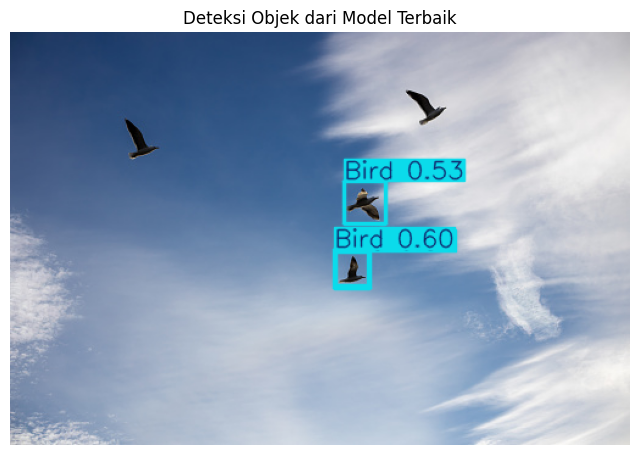

In [16]:
from IPython.display import display

def upload_and_detect():
    print("📸 Silakan upload file gambar (.jpg/.png):")
    uploaded = files.upload()
    image_file = next((f for f in uploaded if f.endswith(('.jpg', '.png'))), None)

    if image_file:
        img = cv2.imread(image_file)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = model_fix.predict(image_file, imgsz=640, conf=0.25)
        result_img = results[0].plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title("Deteksi Objek dari Model Terbaik")
        plt.show()
    else:
        print("File gambar tidak ditemukan. Silakan upload file dengan ekstensi .jpg atau .png.")

upload_and_detect()

📸 Silakan upload file gambar (.jpg/.png):


Saving pesawat 12.jpg to pesawat 12.jpg

image 1/1 /content/pesawat 12.jpg: 416x640 2 Airplanes, 43.9ms
Speed: 2.2ms preprocess, 43.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


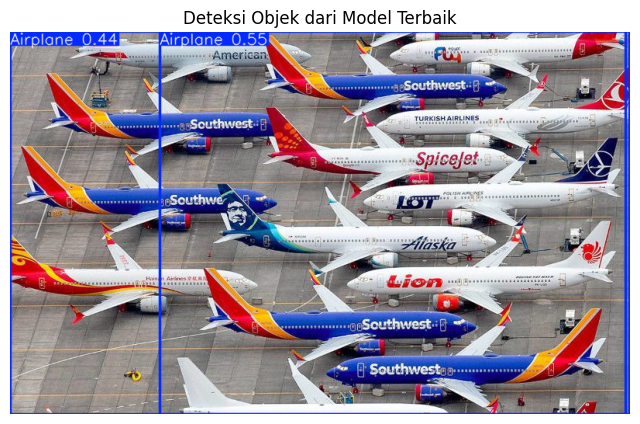

In [17]:
upload_and_detect()

📸 Silakan upload file gambar (.jpg/.png):


Saving drone yolov12.jpg to drone yolov12.jpg

image 1/1 /content/drone yolov12.jpg: 448x640 4 Drones, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


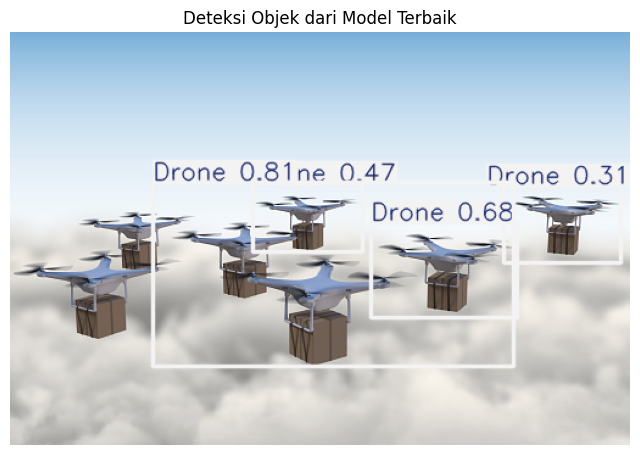

In [18]:
upload_and_detect()

📸 Silakan upload file gambar (.jpg/.png):


Saving 12 heli.jpg to 12 heli.jpg

image 1/1 /content/12 heli.jpg: 384x640 2 Helicopters, 42.8ms
Speed: 2.1ms preprocess, 42.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


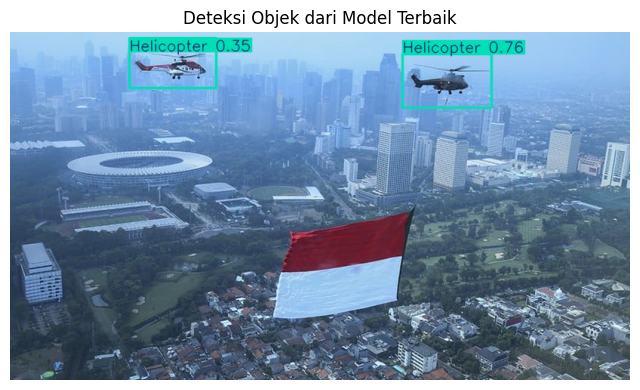

In [19]:
upload_and_detect()